In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
def true_f(x, e=0):
    return x + 0.3 * np.sin(2 * np.pi * (x + e)) + 0.3 * np.sin(4. * np.pi * (x + e))
    #return np.sin(12.0 * x) + 0.66 * np.cos(25.0 * x) + 3.0
    #return np.sin(x)


def get_data(train_size=100, test_size=100):
    n = train_size + test_size

    np.random.seed(42)

    #X = np.linspace(-2.0, 2.0, num=n)
    X = np.random.uniform(-1.0, 1.0, n)
    e = np.random.normal(0, 0.02, n)
    Y = true_f(X, e=e) + e

    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

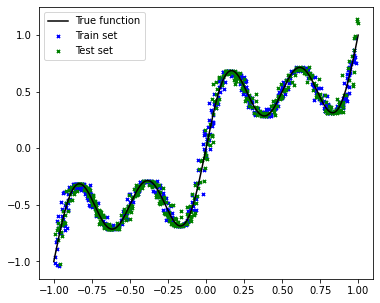

In [5]:
true_x = np.linspace(-1.0, 1.0, 1000)
true_y = true_f(true_x, e=0)

X_train, y_train, X_test, y_test = get_data(500, 500)

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_train, y_train, s=10, marker='x', color='blue', label='Train set')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.legend()

plt.show()

In [6]:
X_train_tensor = torch.from_numpy(X_train.reshape((-1, 1))).float().to(device)
y_train_tensor = torch.from_numpy(y_train.reshape((-1, 1))).float().to(device)

X_test_tensor = torch.from_numpy(X_test.reshape((-1, 1))).float().to(device)
y_test_tensor = torch.from_numpy(y_test.reshape((-1, 1))).float().to(device)

In [54]:
n_hidden = 10

model_seq =  nn.Sequential(
          nn.Linear(1, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, 1)
        ).to(device)

class Reg2L(nn.Module):
    def __init__(self, n_hidden=10, activation=F.tanh):
        super().__init__()
        self.n_hidden = n_hidden
        self.activation = activation
        self.layer1 = nn.Linear(1, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, 2)

    def forward(self, input):
        h1 = self.layer1(input)
        h2 = self.layer2(self.activation(h1))
        h3 = self.layer3(self.activation(h2))
        m = h3[:, :1]
        s = F.softplus(h3[:, 1:]) + 1e-6
        return m, s

model_byhand = Reg2L(n_hidden=n_hidden, activation=F.relu)

In [55]:
num_epoches = 500

optimizer_byhand = torch.optim.Adam(model_byhand.parameters())

for ep in tqdm(range(num_epoches)):
    optimizer_byhand.zero_grad()

    mu, sigma = model_byhand(X_train_tensor)
    #sigma = 1.0
    loss = - torch.distributions.Normal(mu, sigma).log_prob(y_train_tensor).sum()
    loss.backward()
    optimizer_byhand.step()

    if (ep + 1) % 50 == 0:
        with torch.no_grad():
            y_pred, _ = model_byhand(X_test_tensor)
            mse = nn.functional.mse_loss(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

        print(f"Epoch {ep} MSE {mse}")

100%|██████████| 500/500 [00:02<00:00, 210.93it/s]


Epoch 49 MSE 0.1633375883102417
Epoch 99 MSE 0.11411985754966736
Epoch 149 MSE 0.09272991865873337
Epoch 199 MSE 0.07676048576831818
Epoch 249 MSE 0.06279673427343369
Epoch 299 MSE 0.0527554415166378
Epoch 349 MSE 0.04522431269288063
Epoch 399 MSE 0.039376016706228256
Epoch 449 MSE 0.033000119030475616
Epoch 499 MSE 0.027112212032079697


In [56]:
optimizer_seq = torch.optim.Adam(model_seq.parameters())

for ep in tqdm(range(num_epoches)):
    optimizer_seq.zero_grad()

    mu = model_seq(X_train_tensor)
    loss = - torch.distributions.Normal(mu, 1.0).log_prob(y_train_tensor).sum()
    loss.backward()
    optimizer_seq.step()

    if (ep + 1) % 50 == 0:
        with torch.no_grad():
            y_pred = model_seq(X_test_tensor)
            mse = nn.functional.mse_loss(y_pred, y_test_tensor).to(torch.float32).cpu().mean().numpy()

        print(f"Epoch {ep} MSE {mse}")

100%|██████████| 500/500 [00:02<00:00, 231.85it/s]


Epoch 49 MSE 0.19815300405025482
Epoch 99 MSE 0.09564108401536942
Epoch 149 MSE 0.07077562808990479
Epoch 199 MSE 0.06555598974227905
Epoch 249 MSE 0.06175059452652931
Epoch 299 MSE 0.059128180146217346
Epoch 349 MSE 0.05719827488064766
Epoch 399 MSE 0.055482909083366394
Epoch 449 MSE 0.05380316823720932
Epoch 499 MSE 0.052004244178533554


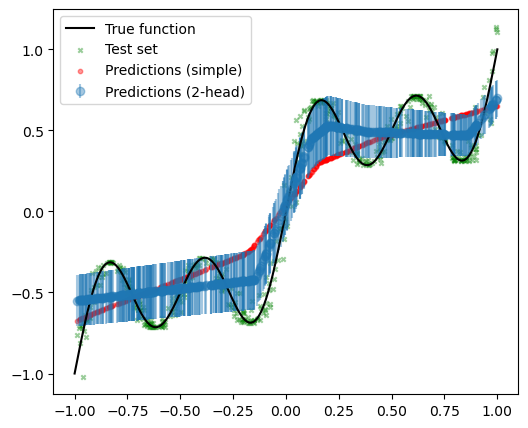

In [57]:
y_pred, sigma_pred = map(lambda x: x.cpu().data.numpy(), model_byhand(X_test_tensor))
y_pred_simple = model_seq(X_test_tensor).cpu().data.numpy()

plt.figure(figsize = (6, 5))
plt.style.use('default')
alpha=0.4

plt.plot(true_x, true_y, color='black', label='True function')

plt.scatter(X_test, y_test, s=10, marker='x', color='green', alpha=alpha, label='Test set')

plt.errorbar(X_test, np.squeeze(y_pred), yerr=np.squeeze(sigma_pred), ls='none', marker='o', alpha=alpha, label='Predictions (2-head)')

plt.scatter(X_test, y_pred_simple, s=10, marker='o', color='red', alpha=alpha, label='Predictions (simple)')

plt.legend()

plt.show()